In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

## Creating the initial optic

We start with creating a conical lens defaulted to be a parabola (k=-1) with N=1000 points to span the space of the top half of the lens. One can start with other conical shapes by inputting the corresponding k value. The inputs are `thick` or the thickness of the lens and `R` which is the radius of curvature. The code only simulates the top half of the optic due to the assumption that the surface is cylindrically symmetric. The equation of the optic is derived from the equation for a conic section with the apex at the origin and solving for r:

\begin{align}
    r^2-2Rz+(K+1)z^2=0\\
    r=\sqrt{2Rz+(K+1)z^2}
\end{align}

One can plug in:
- k=-1 for parabola
- k=0 for spherical
- k>0 for oblate ellipse
- 0>K>−1 for prolate ellipse
- k<-1 for hyperbola

When plugging in the the values for `thick` and `R` one should keep in mind the thin lens approximation where the thickness << R

In [2]:
def create_starting_optic(thick,R,k=-1,N=100):
    z=np.geomspace(1e-6,thick,N) #solves the problem of not having enough points close to the origin
    r=np.sqrt(2*R*z-(k+1)*z**2) 
    optic=np.array([z,r])
    return optic

## Finding the slope for refraction/reflection

The goal of this is to find the normal to any shaped surface. The normal slope will be 1/m for reflected and -1/m for refracted where m is the tangent/slope of the surface at that point

In [3]:
def find_local_eq(r,optic,N=1000):
    # first find nearest point in the lens array to where the ray r intersects
    z=optic[0]
    opt=optic[1]
    index=np.abs(opt-r).argmin()
    
    # isolate a few points around the closest index (look into how many points we actually want)
    lower=index-5
    upper=index+5
        
    local_z=np.array(z[lower:upper])
    local_opt=np.array(opt[lower:upper])-r
    
    # Use cubic spline to interpolate the local points
    cs=CubicSpline(local_z,local_opt)
    zs=np.linspace(local_z[0],local_z[-1],N)
    return zs,cs

In [4]:
def find_norm(z,cs):
    # find the normal to the surface
    tang=cs(z,1) # 1st derivative of the spline at point z
    norm=-1/tang
    return norm

`find_reflect_slope` takes the given normal slope to calculate the angle 2$\theta$ where $\theta$ is the angle that the incoming ray makes with the normal to the surface. 

In [5]:
def find_reflect_slope(norm):
    theta=np.arctan(norm)
    slope=np.tan(2*theta)
    return slope

`find__refract_slope` finds the slope of the ray after it refracts off of the surface. `norm` is the normal of the surface and is used to find the angle $\phi_1$ which is the angle between the incident ray and the normal of the surface. This function returns the slope of the ray that refracts after encountering the surface using Snell's law 

In [6]:
def find_refract_slope(norm,n1,n2):
    phi1=np.arctan(norm)
    sinphi2=n1*np.sin(phi1)/n2
    phi2=np.arcsin(sinphi2)
    theta=phi1-phi2
    slope=np.tan(theta)
    return slope

## Raytracing

Now that we have the algorithm to find the slope normal to the surface we can simulate the ray propagation. We only need to calculate for two points:where the ray meets the surface the optic and where the ray crosses the optical axis. Additional functionality can be added later for multiple optics. Also need to change the input rays to be ray vectors instead. This code does both refraction and reflection.

In [7]:
def raytrace(optic, Nr=7, refract=False):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[5]
    r_max=opt[-10]
    
    rays=np.linspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for r in rays:
        zs,cs=find_local_eq(r,optic)
        z_optic=cs.roots()
        if len(z_optic)>1:
            print('Warning: multiple intersections with lens found') # many roots are usually found near r=0
        
        norm=find_norm(z_optic[0],cs)
        slope=find_refract_slope(norm,1,3) if refract else find_reflect_slope(norm)
        z_after=(-r/slope+z_optic[0]) # This is where the ray should intersect the z axis
        z_bef=-1 if refract else z_after*1.5 # change this so that z_bef all starts at the same z value
        z_ray=[z_bef,z_optic[0],z_after]
        r_ray=[r,r,0]            
        raymatrix.append([z_ray,r_ray])
        after.append(z_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [8]:
def plot(optic,raymatrix,exp_f,title, lambda0=None, norm=False,savefig=False):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    opt_z=optic[0] if not norm else optic[0]/lambda0
    opt_r=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'b',opt_z,-1*opt_r,'b')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    for ray in raymatrix:
        ray_z=ray[0] if not norm else ray[0]/lambda0
        ray_r=ray[1] if not norm else ray[1]/lambda0
        plt.plot(ray_z,ray_r,'r',ray_z,-1*ray_r,'r')
        
    xl='z (m)' if not norm else 'z/lambda'
    yl='r (m)' if not norm else 'r/lambda'
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    if savefig:
        plt.savefig(title+".png")
    plt.show()


## `create_hist`
Creates a histogram of where the rays meet on the z axis after the ray encounters the optic. The function uses [Sturge's Formula](https://en.wikipedia.org/wiki/Histogram#Sturges'_formula) to calculate the number of bins. We use the Rayleigh criterion as the bin width: $\Delta\theta = 1.22\lambda/D$ where $\lambda$ is the wavelength and $D$ is the diameter of the optic. This is calculated with the function `calc_bw`. This function also rounds to the nearest 6th decimal by default which corresponds to the nearest micrometer for the physical case we've defined later in this notebook.  We set the bin number to be odd so that we have the expected focal length bin always as our center bar (this may need to be altered). We set the range as the $[f_{exp} - \frac{1}{2}k \Delta\theta, f_{exp} + \frac{1}{2}k\Delta\theta]$. 

In [9]:
def calc_bw(lambda0,diam,dec=6):
    ang_res= 1.22*lambda0/diam # The bin width is set as the minimum resolution 
    return np.around(ang_res,dec) 

In [10]:
def create_hist(rays_after,exp_f, bin_width, plot=False, lambda0=None, norm=False, savefig=False):
    n=len(rays_after)    
    #make k odd so that we have even number of bin below and above the expected focal value
    k=int(np.ceil(np.log2(n)))+1
    if k%2==0:
        k+=1
    
    bw=bin_width if not norm else bin_width/lambda0
    exp_freq=exp_f if not norm else exp_f/lambda0
    bin_low=exp_freq-bw*(0.5*k)
    bin_high=exp_freq+bw*(0.5*k)
    
    bins=np.linspace(bin_low,bin_high,k+1)
    
    rays = rays_after if not norm else rays_after/lambda0
    hist=np.histogram(rays,bins)
    
    #plots the histogram
    if plot:
        fig,ax=plt.subplots(figsize=(15,10))
        ax.hist(rays,bins)
        xl='z (m)' if not norm else 'z/lambda'
        ax.set_xlabel(xl)
        ax.ticklabel_format(useOffset=False)
        ax.set_xticks(bins)
        title="Expected f: %f m" % (exp_f)
        ax.set_title(title)
        if savefig:
            plt.savefig(title+"_hist.png")

        plt.show()
    return hist

## The cost function

The cost function is the chi-square goodness-of-fit test which is shown below:

\begin{equation}
    \chi^2=\sum_{i=1}^{k}(O_i-E_i)^2/E_i
\end{equation}

where $O_i$ is the observed frequency for bin $i$ and $E_i$ is the expected frequency for bin $i$. For our case we want to have all of our rays meet at the same point i.e have them all in the same bin. Therefore, the expected frequency for all of the non zero bins will be the total number of rays. We will need to minimize the chi-square value in order to get the optimal optic. 

In [11]:
def chi_square(hist):
    nr=np.sum(hist)
    Oi=hist
    Ei=np.zeros(len(hist))
    index=ceil(len(hist)/2)
    Ei[index]=nr
    chi_square=np.sum((Oi-Ei)**2)
    return chi_square

## Reflecting Raytracing
[ThorLabs](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=112)
![image.png](75mm_lenses.png)
![drawing](Plano-Convex_Lens_Schematic.jpg)

Expected: focal point for a parabola is characterized by the equation $f=\frac{r^2}{4S}$ where r is the radius of the parabola and S is the sag or the thickness. 

In the code's definition the thickness if S=$t_e-t_c$. 

In the axiparabola paper, they say that the diameter of the axiparabola mirror they used was a 76.2 mm diameter aluminum mirror. The table above shows the actual dimensions of 75 mm aluminum coated mirrors that they sell. The table above will be used to test.

In [12]:
import pandas as pd
tc=np.ones(5)*12/1000
te=np.array([18.4,16.7,14.3,13.7,12.7])/1000
radoc=np.array([112.5,150.0,300.0,400.0,1000.0])/1000
exp_foc=np.array([56.25,75,150,200,500])/1000
al75=pd.DataFrame(data={'t_c':tc,'t_e':te, 'S':te-tc, 'ROC':radoc, 'exp_f':exp_foc})

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


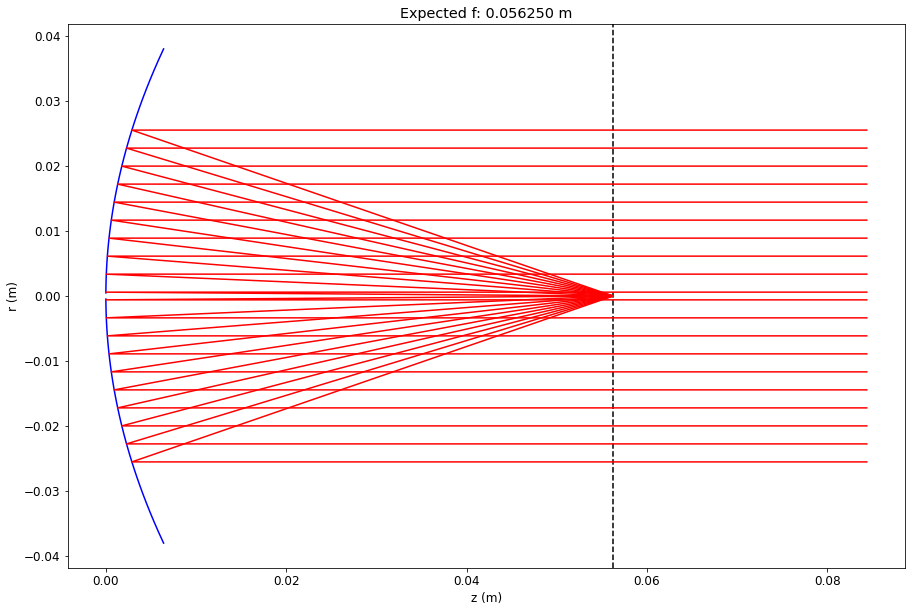

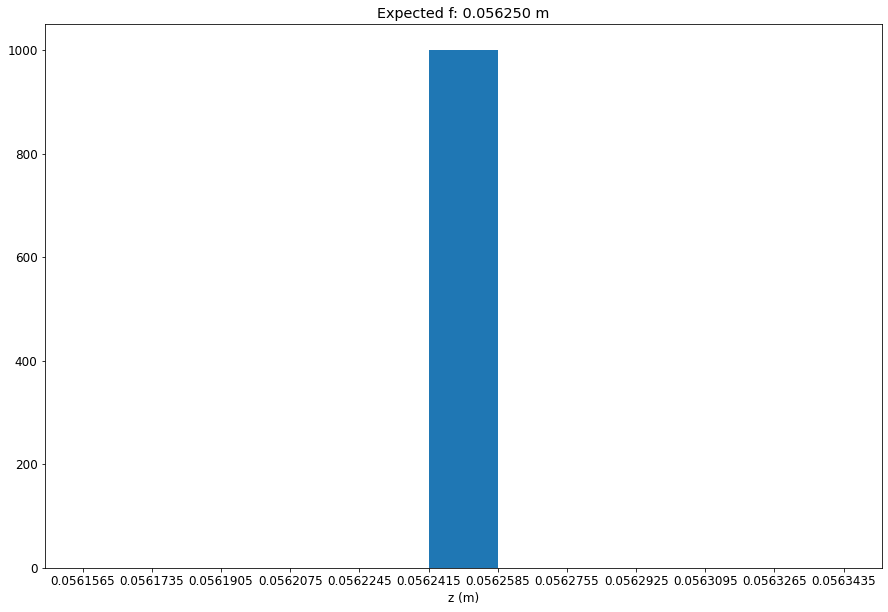

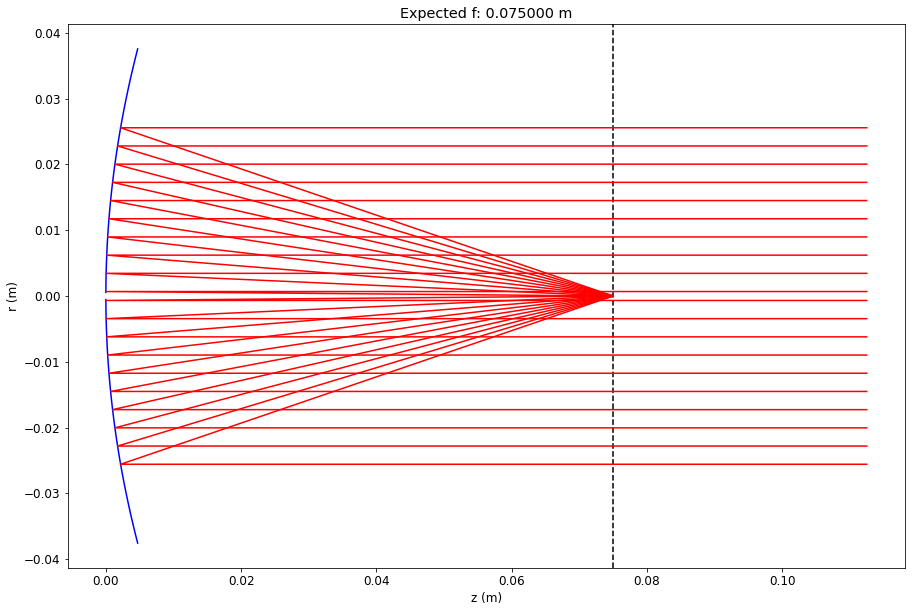

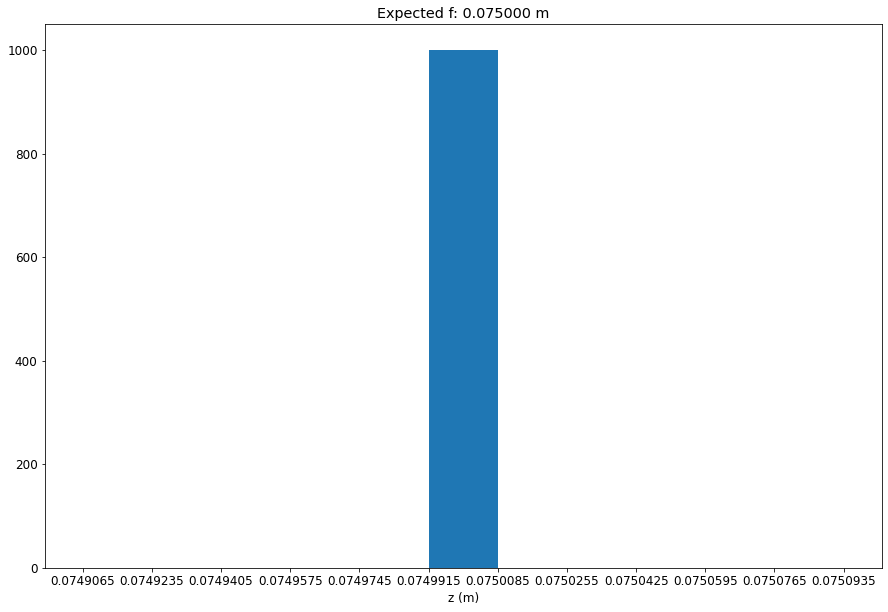

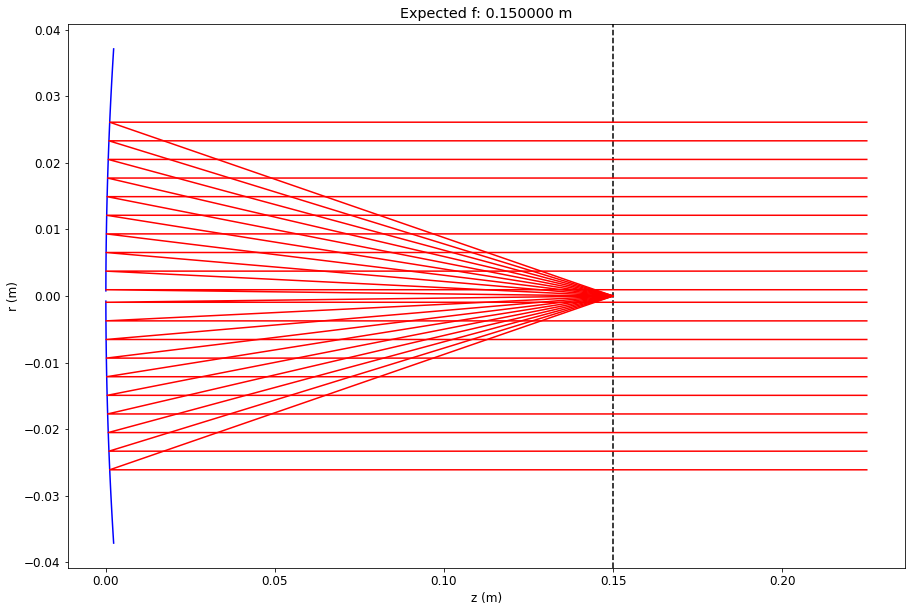

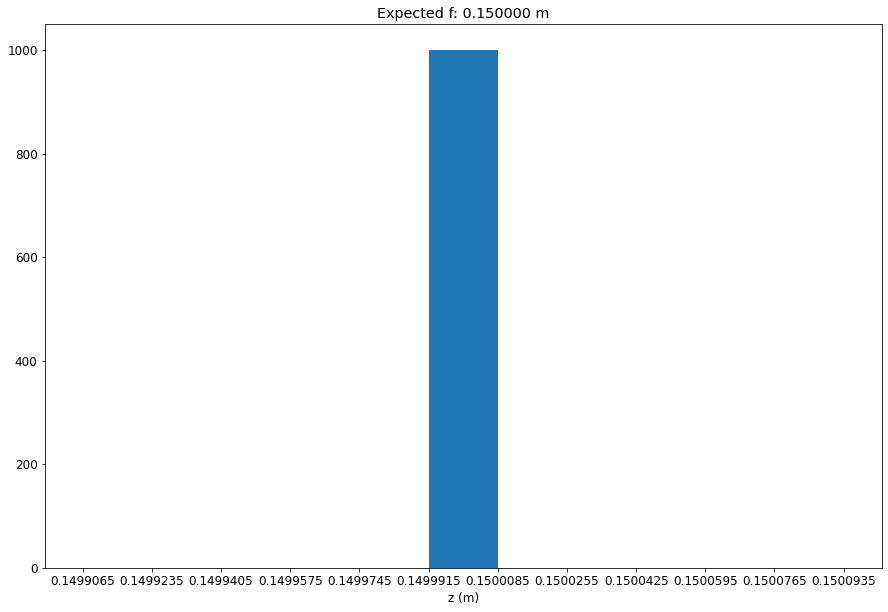

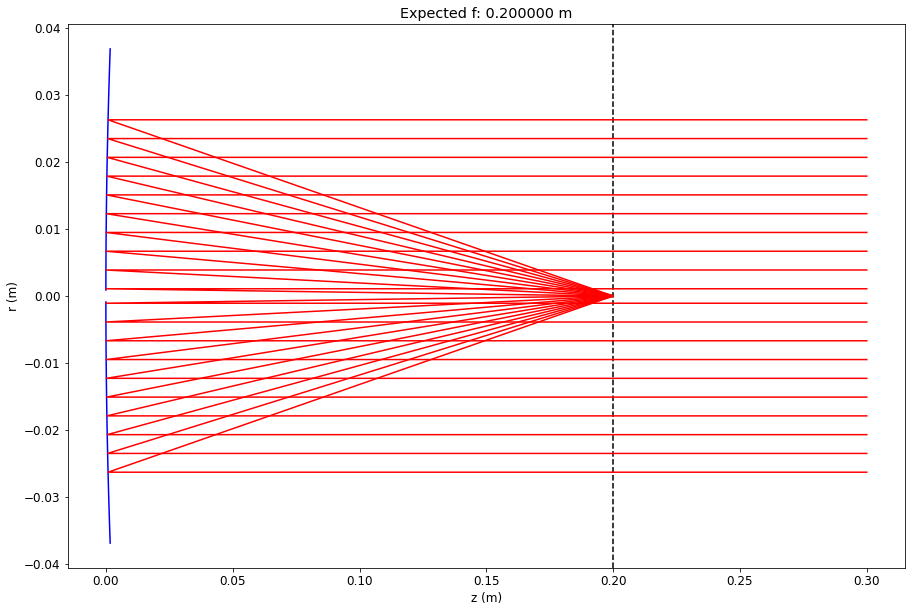

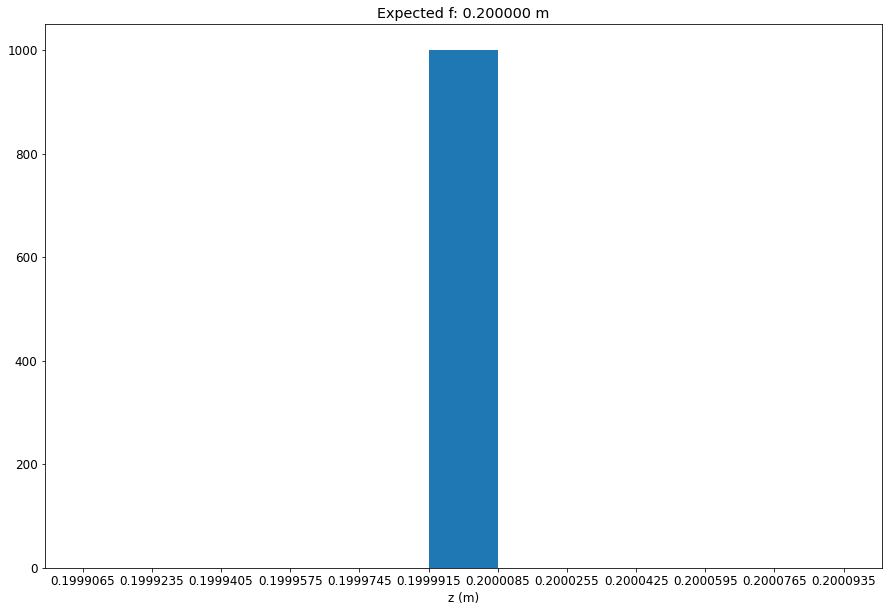

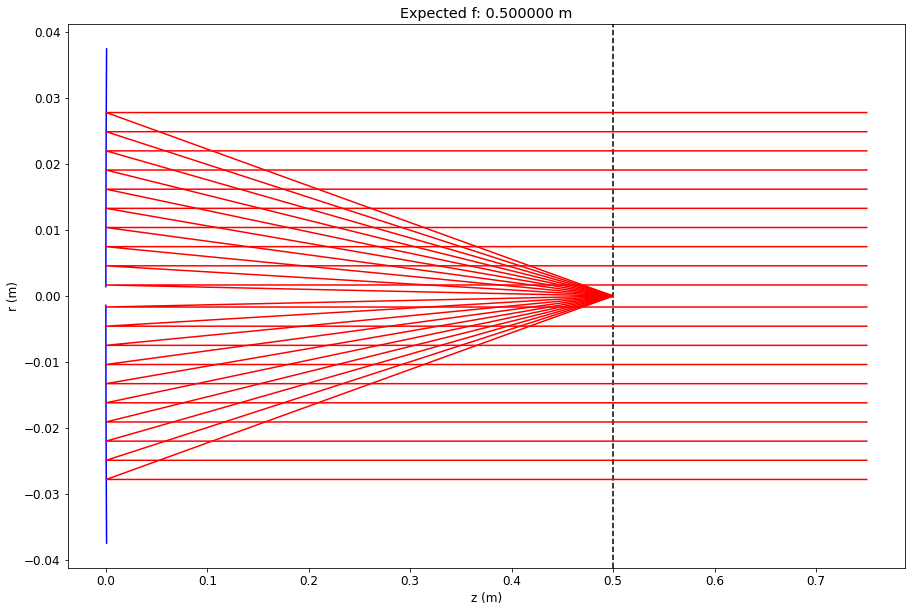

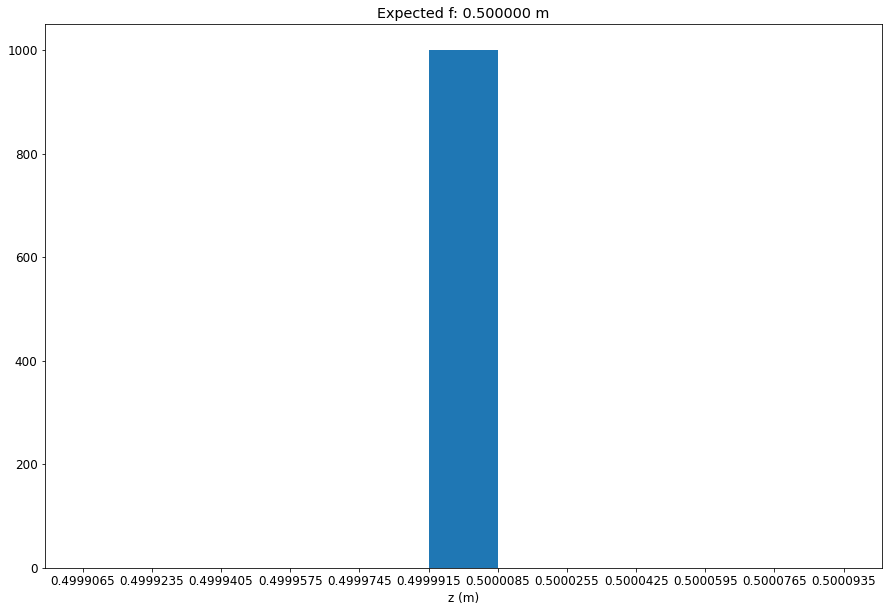

In [13]:
for index,row in al75.iterrows():
    #read the table values
    s=row['S']
    roc=row['ROC']
    exp_f=row['exp_f']
    
    o=create_starting_optic(s,roc,k=-1)
    #Set it to 10 rays at first for the plot
    mir_rm,mir_af=raytrace(o,refract=False,Nr=10)
    plot(o,mir_rm,exp_f,"Expected f: %f m" % (exp_f),savefig=True)
    
    #Now set the number of rays to 1000 for a good sample size
    mir_rm,mir_af=raytrace(o,refract=False,Nr=1000)
    lambda0=1.054e-6 #m
    diam=0.075 #m
    bw=calc_bw(lambda0,diam)
    mir_hist,mir_bin_range=create_hist(mir_af,exp_f, bw,plot=True,savefig=True)
    #print(mir_af-exp_f)